In [1]:
%config Completer.use_jedi = False

In [2]:
from regrid import regrid
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pickle
from calendar import monthrange
import mask
import tqdm
import pickle
import cartopy.crs as ccrs
import cartopy
import datetime
import pandas as pd
import itertools
from cartoplot import cartoplot

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [3]:
with Dataset('/media/robbie/Brokendrive/E5/ERA_nh_1973_12.nc') as ERA5_data:
    lons = np.array(ERA5_data['longitude'])
    lats = np.array(ERA5_data['latitude'])
    
ERA5_lon_grid = np.array([np.array(lons), ] * 121)
ERA5_lat_grid = np.array([np.array(lats), ] * 1440).T

conc_dict = pickle.load(open('../processors/conc_dict.p','rb'))

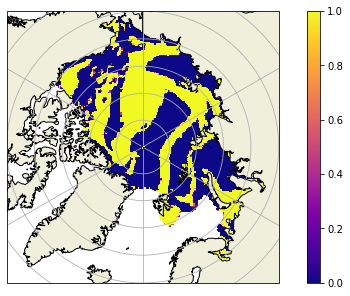

In [4]:
def month_conc_mask(input_array,sic):
    
    m3d = np.repeat(sic[np.newaxis,:,:],input_array.shape[0],axis=0)
    
    output = np.multiply(input_array,m3d)
    
    return(output)
    
year = 2020
month = 2

elons, elats = mask.get('lon'), mask.get('lat')

sic = conc_dict[month][year]

d = Dataset(f'/media/robbie/TOSHIBA EXT/vorticity_files/{year}{str(month).zfill(2)}.nc')

dat = np.array(d['vort_3hr'])

mm = month_conc_mask(dat,sic)

cartoplot(elons,elats,mm[10],color_scale=(0,1))

In [10]:
years = np.arange(1980,2022)
months = [12,1,2] 

list_of_dicts = []

hourly_means = []

for year in tqdm.tqdm(years):

    mean3h = []
    
    for month in months:
        
        get_year = year if month in [1,2] else year-1    
        
        d = Dataset(f'/media/robbie/TOSHIBA EXT/vorticity_files/{get_year}{str(month).zfill(2)}.nc')
        
        vort_field = np.array(d['vort_3hr'])

        sic = conc_dict[month][get_year]
        
        masked_3d_vort = month_conc_mask(vort_field,sic)
    
        m = np.nanmean(masked_3d_vort, axis=(1,2))

        mean3h += list(m)
        
    hourly_means.append(mean3h)

100%|██████████| 42/42 [03:42<00:00,  5.31s/it]


In [17]:
pickle.dump(hourly_means,open('../figure1_current/vorts.p','wb'))

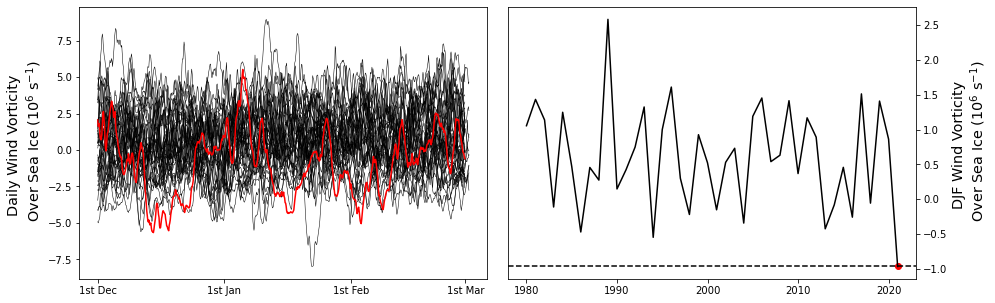

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ann_means = []

for counter, year in enumerate(years):
    
    if year == 2021:
        color = 'r'
        lw=1.5

    else:
        color = 'k'
        lw=0.5
    
    ax1.plot(hourly_means[counter],color=color,lw=lw)
    
    ann_means.append(np.mean(hourly_means[counter]))
    
ax2.plot(years,ann_means,color='k')
ax2.scatter(years[-1],ann_means[-1],color='r',marker='o')

ax1.set_xticks([0,(31)*8,(31+31)*8,(31+31+28)*8])
ax1.set_xticklabels(['1st Dec', '1st Jan', '1st Feb', '1st Mar'])

vor_units = r'(10$^6$ s$^{-1}$)'
ax1.set_ylabel(f'Daily Wind Vorticity \n Over Sea Ice {vor_units}', fontsize='x-large')
ax2.set_ylabel(f'DJF Wind Vorticity \n Over Sea Ice {vor_units}', fontsize='x-large')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.axhline(ann_means[-1], color='k',ls='--')


plt.subplots_adjust(wspace=0.05)

# Make Figure 1b

In [21]:
month_mean_winds = {}

for year in tqdm.trange(1979,2022):
    
    with Dataset(f'/media/robbie/TOSHIBA EXT/E5/{year}.nc') as ERA5_data:
       
    
#         print(ERA5_data['expver'][1])

        months = range(1,13) if year != 2021 else [1,2]

        d=0
        for month in range(1,13):

            days_in_month = monthrange(year,month)[1]     

            if month in [12,1,2]:
                        
#                 if year != 2020:

                v10 = np.array(ERA5_data['v10'][d*8:(d+days_in_month)*8])
                u10 = np.array(ERA5_data['u10'][d*8:(d+days_in_month)*8])

#                 elif (year == 2020) & (month < 12):

#                     v10 = np.array(ERA5_data['v10'][d*8:(d+days_in_month)*8,0])
#                     u10 = np.array(ERA5_data['u10'][d*8:(d+days_in_month)*8,0])

#                 else:            

#                     v10 = np.array(ERA5_data['v10'][d*8:(d+days_in_month)*8,1])
#                     u10 = np.array(ERA5_data['u10'][d*8:(d+days_in_month)*8,1])

                mean_u = np.nanmean(u10,axis=0)
                mean_v = np.nanmean(v10,axis=0)
                
                month_mean_winds[(month,year)] =  {'u':mean_u,
                                                   'v':mean_v}
                

            d += days_in_month      

            

 98%|█████████▊| 42/43 [07:06<00:10, 10.37s/it]/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
100%|██████████| 43/43 [07:13<00:00, 10.08s/it]


In [22]:
pickle.dump(month_mean_winds, open('../pickles/wind_climatology.p', 'wb'))

month_mean_winds = pickle.load(open('../pickles/wind_climatology.p', 'rb'))

In [23]:
climatology_keys = []
for key in month_mean_winds.keys():
    if (key[1] < 2021) & (key != (12,2020)):
        climatology_keys.append(key)

In [24]:
climatology_3d = np.full((2,len(climatology_keys),ERA5_lat_grid.shape[0],ERA5_lat_grid.shape[1]), np.nan)

for i, key in enumerate(climatology_keys):
    
    climatology_3d[0][i] = month_mean_winds[key]['u']
    climatology_3d[1][i] = month_mean_winds[key]['v']
    
climatology_2d = np.nanmean(climatology_3d, axis=1)

climatology_2d.shape

(2, 121, 1440)

## Regrid climatology to EASE and rotate to xy frame

In [25]:
ease_lons = mask.get('lon'); ease_lats = mask.get('lat')

ease_u_climatology = regrid(climatology_2d[0],
                            ERA5_lon_grid,ERA5_lat_grid,
                            ease_lons,ease_lats,
                            method='nearest')

ease_v_climatology = regrid(climatology_2d[1],
                            ERA5_lon_grid,ERA5_lat_grid,
                            ease_lons,ease_lats,
                            method='nearest')

ease_cos_lons, ease_sin_lons = np.cos(np.deg2rad(ease_lons)), np.sin(np.deg2rad(ease_lons))

c_x10 = np.multiply(ease_u_climatology,ease_cos_lons) - np.multiply(ease_v_climatology,ease_sin_lons)
c_y10 = np.multiply(ease_u_climatology,ease_sin_lons) + np.multiply(ease_v_climatology,ease_cos_lons)

c_x10[180,180] = c_x10[181,181]
c_y10[180,180] = c_y10[181,181]


c_ease_wind_speed = np.sqrt( np.square(c_x10) + np.square(c_y10))

norm_c_x10 = np.divide(c_x10, c_ease_wind_speed)
norm_c_y10 = np.divide(c_y10, c_ease_wind_speed)

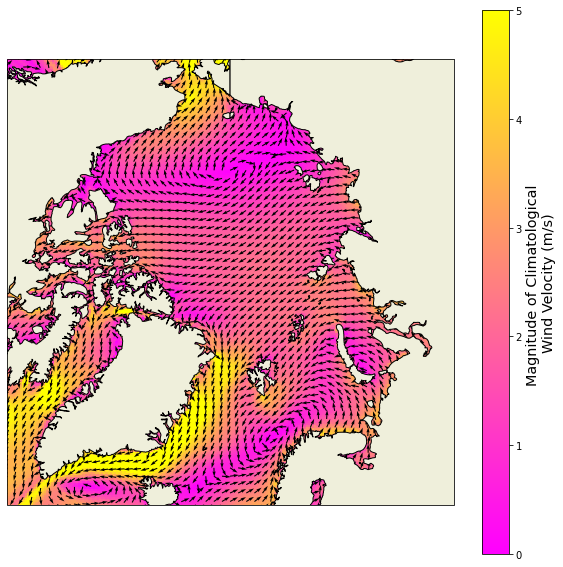

In [27]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.margins()

s = 4
scale = 50
size_lim = 1000

bg = ax.pcolormesh(ease_lons, 
                   ease_lats, 
                   c_ease_wind_speed[:-1,:-1], 
                    vmin = 0, 
                    vmax = 5,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=1)

qv =   ax.quiver(ease_lons[::s,::s],
                 ease_lats[::s,::s],
                 norm_c_x10[::s,::s],
                 norm_c_y10[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )

qv.set_UVC(U=norm_c_x10[::s,::s], V=norm_c_y10[::s,::s])

cb = plt.colorbar(bg)
cb.set_label('Magnitude of Climatological \nWind Velocity (m/s)', fontsize='x-large')

# Calculate DJF winds

In [28]:
anomaly_keys = [(12, 2020), (1, 2021), (2, 2021)]

anomaly_3d = np.full((2,len(anomaly_keys),ERA5_lat_grid.shape[0],ERA5_lat_grid.shape[1]), np.nan)

for i, key in enumerate(anomaly_keys):
    
    anomaly_3d[0][i] = month_mean_winds[key]['u']
    anomaly_3d[1][i] = month_mean_winds[key]['v']
    
anomaly_2d = np.nanmean(anomaly_3d, axis=1)

anomaly_2d.shape

(2, 121, 1440)

In [29]:
ease_u_djf = regrid(anomaly_2d[0],
                            ERA5_lon_grid,ERA5_lat_grid,
                            ease_lons,ease_lats,
                            method='nearest')

ease_v_djf = regrid(anomaly_2d[1],
                            ERA5_lon_grid,ERA5_lat_grid,
                            ease_lons,ease_lats,
                            method='nearest')

ease_cos_lons, ease_sin_lons = np.cos(np.deg2rad(ease_lons)), np.sin(np.deg2rad(ease_lons))

djf_x10 = np.multiply(ease_u_djf,ease_cos_lons) - np.multiply(ease_v_djf,ease_sin_lons)
djf_y10 = np.multiply(ease_u_djf,ease_sin_lons) + np.multiply(ease_v_djf,ease_cos_lons)
djf_x10[180,180] = djf_x10[181,181]
djf_y10[180,180] = djf_y10[181,181]

djf_ease_wind_speed = np.sqrt( np.square(djf_x10) + np.square(djf_y10))

norm_djf_x10 = np.divide(djf_x10, djf_ease_wind_speed)
norm_djf_y10 = np.divide(djf_y10, djf_ease_wind_speed)

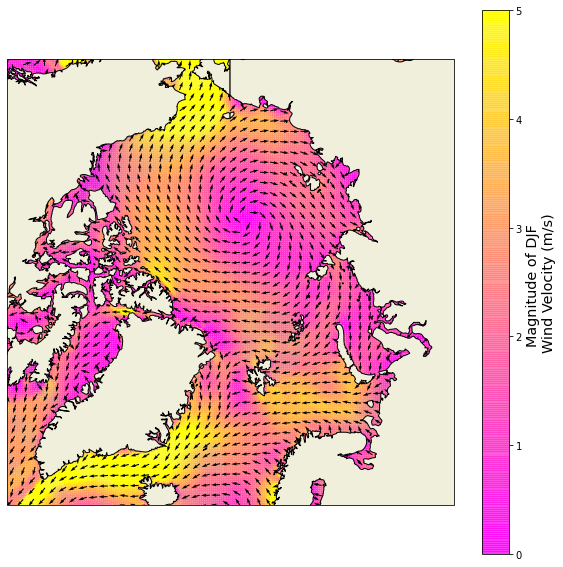

In [30]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.margins()

s = 5
scale = 50
size_lim = 1000

bg = ax.pcolormesh(ease_lons, 
                   ease_lats, 
                   djf_ease_wind_speed[:-1,:-1], 
                    vmin = 0, 
                    vmax = 5,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=0.8)

qv =   ax.quiver(ease_lons[::s,::s],
                 ease_lats[::s,::s],
                 norm_djf_x10[::s,::s],
                 norm_djf_y10[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )


qv.set_UVC(U=norm_djf_x10[::s,::s], V=norm_djf_y10[::s,::s])

cb = plt.colorbar(bg)

cb.set_label('Magnitude of DJF \nWind Velocity (m/s)',fontsize='x-large')

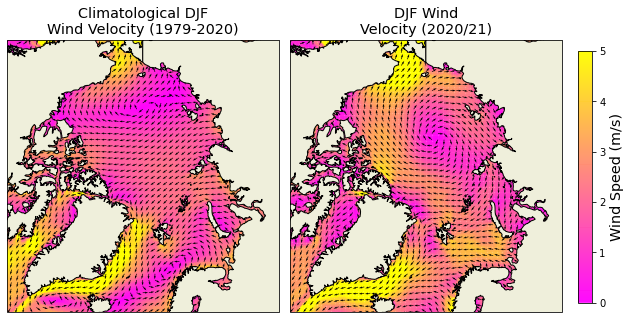

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),subplot_kw={'projection': ccrs.NorthPolarStereo()})

ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax1.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax1.margins()

s = 5
scale = 50
size_lim = 1000

bg = ax1.pcolormesh(ease_lons, 
                   ease_lats, 
                   c_ease_wind_speed[:-1,:-1], 
                    vmin = 0, 
                    vmax = 5,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=1)

qv =   ax1.quiver(ease_lons[::s,::s],
                 ease_lats[::s,::s],
                 norm_c_x10[::s,::s],
                 norm_c_y10[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )

qv.set_UVC(U=norm_c_x10[::s,::s], V=norm_c_y10[::s,::s])


ax1.set_title('Climatological DJF\nWind Velocity (1979-2020)', fontsize='x-large')

####################

ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax2.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax2.margins()


bg = ax2.pcolormesh(ease_lons, 
                   ease_lats, 
                   djf_ease_wind_speed[:-1,:-1], 
                    vmin = 0, 
                    vmax = 5,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=0.8)

qv =   ax2.quiver(ease_lons[::s,::s],
                 ease_lats[::s,::s],
                 norm_djf_x10[::s,::s],
                 norm_djf_y10[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )


qv.set_UVC(U=norm_djf_x10[::s,::s], V=norm_djf_y10[::s,::s])

ax2.set_title('DJF Wind\nVelocity (2020/21)',fontsize='x-large')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

cb = fig.colorbar(bg, cax=cbar_ax)

cb.set_label('Wind Speed (m/s)', fontsize='x-large')

plt.subplots_adjust(wspace=0.03)

In [32]:
pickle.dump((norm_djf_x10,norm_djf_y10,djf_ease_wind_speed, norm_c_x10, norm_c_y10, c_ease_wind_speed),
            open('../pickles/wind_anoms.p','wb'))

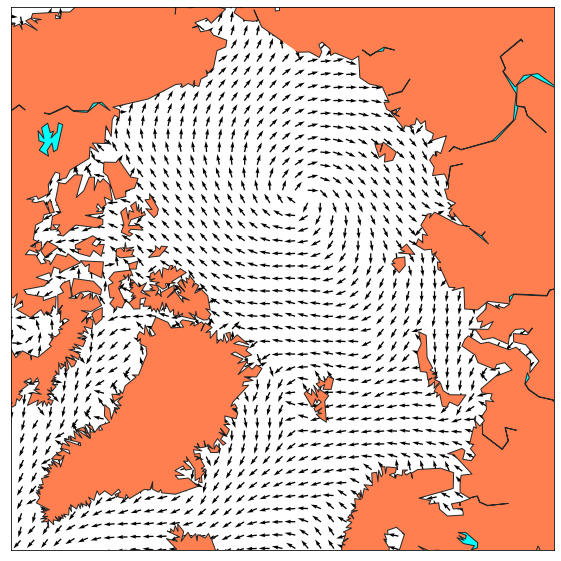

In [33]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(10,10))

m = Basemap(projection="npstere", boundinglat = 66,  lon_0 = 0)

m.drawcoastlines(color = '0.15')
m.fillcontinents(color='coral',lake_color='aqua')


m.quiver(ease_lons[::s,::s],
                 ease_lats[::s,::s],
                 norm_djf_x10[::s,::s],
                 norm_djf_y10[::s,::s],
                 latlon=True,
                 angles='xy',
                 scale=50)


# ax = plt.axes(projection=ccrs.NorthPolarStereo())

# ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

# # qv =   ax.quiver(ease_lons[::s,::s],
# #                  ease_lats[::s,::s],
# #                  norm_djf_x10[::s,::s],
# #                  norm_djf_y10[::s,::s],
# #                  transform=ccrs.PlateCarree(),
# #                  scale=scale,
# #                 )


# # qv.set_UVC(U=norm_djf_x10[::s,::s], V=norm_djf_y10[::s,::s])


plt.show()

In [34]:
a_x10 = djf_x10 - c_x10
a_y10 = djf_y10 - c_y10

a_ease_wind_speed = np.sqrt( np.square(a_x10) + np.square(a_y10))

norm_a_x10 = np.divide(a_x10, a_ease_wind_speed)
norm_a_y10 = np.divide(a_y10, a_ease_wind_speed)

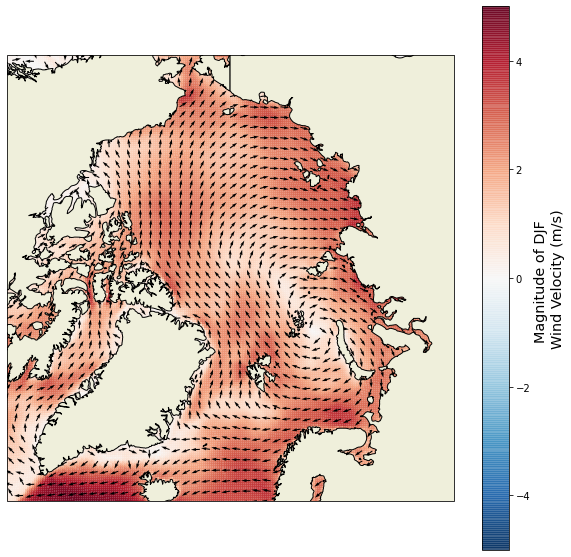

In [35]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.margins()

s = 5
scale = 50
size_lim = 1000

bg = ax.pcolormesh(ease_lons, 
                   ease_lats, 
                   a_ease_wind_speed[:-1,:-1], 
                    vmin = -5, 
                    vmax = 5,
                    transform=ccrs.PlateCarree(),
                    cmap='RdBu_r',
                    alpha=0.8)

qv =   ax.quiver(ease_lons[::s,::s],
                 ease_lats[::s,::s],
                 norm_a_x10[::s,::s],
                 norm_a_y10[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )


qv.set_UVC(U=norm_a_x10[::s,::s], V=norm_a_y10[::s,::s])

cb = plt.colorbar(bg)

cb.set_label('Magnitude of DJF \nWind Velocity (m/s)',fontsize='x-large')

In [36]:
import matplotlib.image as mpimg

img = mpimg.imread('temporary_files/ghp.png')

plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: 'temporary_files/ghp.png'

In [37]:
from mask import select_region

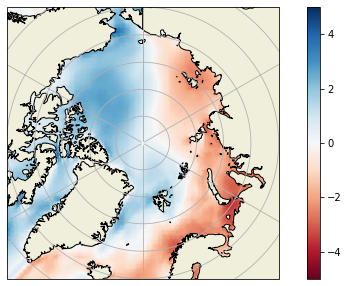

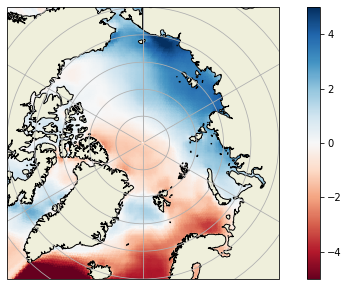

In [211]:

cartoplot(ease_lons, ease_lats, a_y10,color_scale=(-5,5),color_scheme=('RdBu'))
cartoplot(ease_lons, ease_lats, a_x10,color_scale=(-5,5),color_scheme=('RdBu'))

# Now make a DJF vorticity anomaly plot

124


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


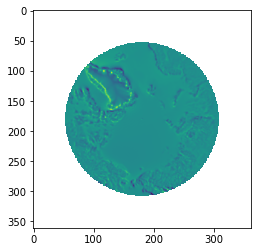

In [167]:
v_dir = '/home/robbie/Dropbox/beaufort_sea/vorticity_files'

c_vort_3d = np.full((len(climatology_keys),ease_lons.shape[0],ease_lats.shape[1]),np.nan)

for i, (month, year) in enumerate(climatology_keys):
    with Dataset(f'{v_dir}/{year}{str(month).zfill(2)}.nc') as d:
        
        c_vort_3d[i] = np.array(d['vort_ave'])

vort_climatology = np.nanmean(c_vort_3d,axis=0)
print(i)
plt.imshow(vort_climatology)

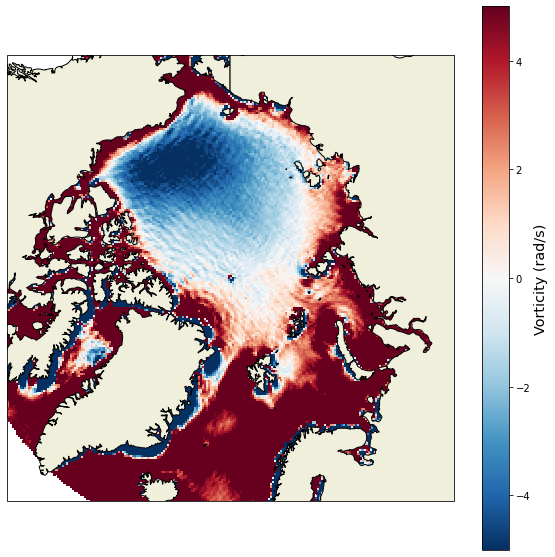

In [168]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.margins()

s = 5
scale = 70
size_lim = 1000

bg = ax.pcolormesh(ease_lons, 
                   ease_lats, 
                   vort_climatology[:-1,:-1], 
                    vmin = -5, 
                    vmax = 5,
                    transform=ccrs.PlateCarree(),
                    cmap='RdBu_r',
                    alpha=1)

cb = plt.colorbar(bg)

cb.set_label('Vorticity (rad/s)',fontsize='x-large')

In [155]:
from cartoplot import cartoplot

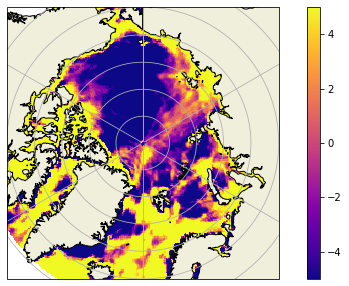

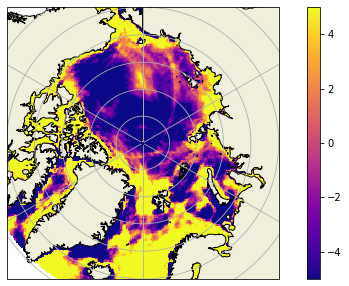

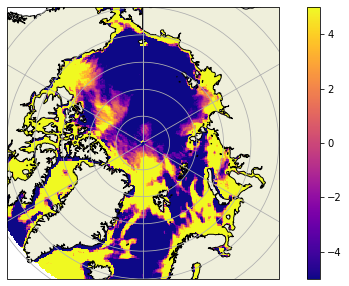

2


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


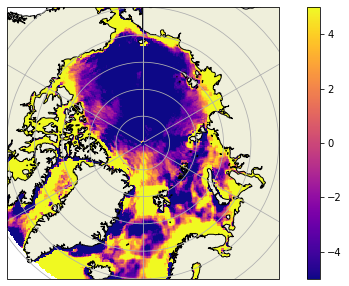

(361, 361)

In [169]:
anomaly_keys = [(12, 2020), (1, 2021), (2, 2021)]

a_vort_3d = np.full((len(anomaly_keys),ease_lons.shape[0],ease_lats.shape[1]),np.nan)

for i, (month, year) in enumerate(anomaly_keys):
    with Dataset(f'{v_dir}/{year}{str(month).zfill(2)}.nc') as d:
        
        a_vort_3d[i] = np.array(d['vort_ave'])
        
        cartoplot(ease_lons,ease_lats, d['vort_ave'],color_scale=(-5,5))
print(i)
        
vort_djf = np.nanmean(a_vort_3d,axis=0)

cartoplot(ease_lons, ease_lats, vort_djf,color_scale=(-5,5))

vort_djf.shape

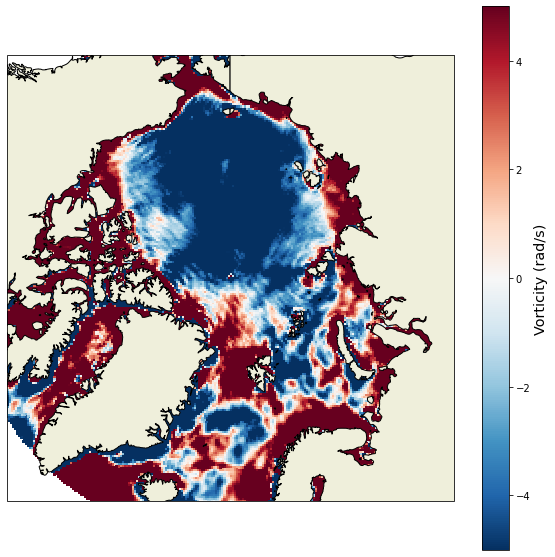

In [170]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.margins()

s = 5
scale = 70
size_lim = 1000

bg = ax.pcolormesh(ease_lons, 
                   ease_lats, 
                   vort_djf[:-1,:-1], 
                    vmin = -15, 
                    vmax = 5,
                    transform=ccrs.PlateCarree(),
                    cmap='RdBu_r',
                    alpha=1)

cb = plt.colorbar(bg)

cb.set_label('Vorticity (rad/s)',fontsize='x-large')

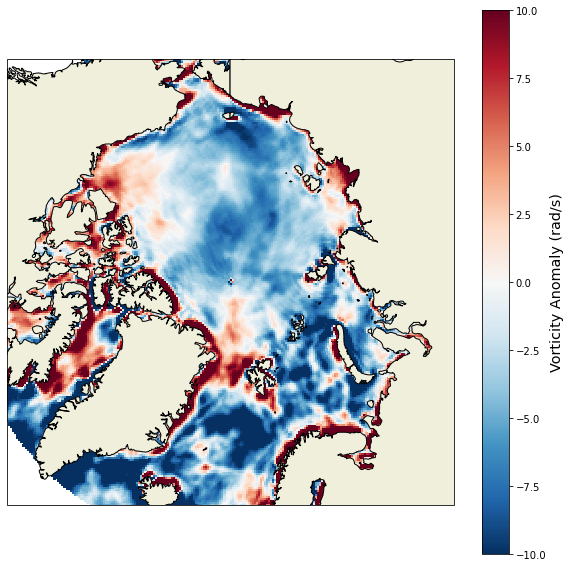

In [174]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.margins()

s = 5
scale = 70
size_lim = 1000

bg = ax.pcolormesh(ease_lons, 
                   ease_lats, 
                   (vort_djf-vort_climatology)[:-1,:-1], 
                    vmin = -10, 
                    vmax = 10,
                    transform=ccrs.PlateCarree(),
                    cmap='RdBu_r',
                    alpha=1)

cb = plt.colorbar(bg)

cb.set_label('Vorticity Anomaly (rad/s)',fontsize='x-large')

# Establish vorticity record

In [175]:
from importlib import reload
reload(mask)
import mask
from cartoplot import cartoplot
from regrid import regrid

mask_lons = mask.get('lon')
mask_lats = mask.get('lat')
my_mask = mask.get('mask')

basin = mask.select_region('basin_no_barents',my_mask)

basin_binary = ~np.isnan(basin)

ERA_basin_binary = regrid(basin_binary,mask_lons,mask_lats,ERA5_lon_grid,ERA5_lat_grid)

mon_ERA5_bb = np.swapaxes(np.repeat(ERA_basin_binary[:,:,np.newaxis],31*8,axis=2).T,1,2)

mon_ERA5_bb.shape

(248, 121, 1440)

In [177]:
def mask_for_basin(array,basin_mask,fill_with_nans=False):
    x = np.ma.masked_where(basin_mask != 1, array)
    if fill_with_nans: x = np.ma.filled(x,np.nan)
    return(x)

In [184]:
data_dir = '/home/robbie/Dropbox/beaufort_sea/vorticity_files/'


for year in tqdm.trange(2020,2022):
    
    times_daily = {}
    mean_vort_daily = {}
    
    monthrange = range(1,13) if year != 2021 else range(1,3)
    
    for month in monthrange:
        
        with Dataset(f'{data_dir}{year}{str(month).zfill(2)}.nc') as vort_data:
              
            # Get a month worth of vorticity fields
            
            vort = np.array(vort_data['vort_3hr'][:])
            
            # Mask the vorticity field for the basin
            
            # This involves applying a 3D mask to the 3D vort array, in ERA5 coords
            
            for i in range(vort.shape[0]):
            
                vort[i] = mask.select_region('basin_no_barents', vort[i])
            
            # Make a 3D array of latitude weightings

            vort_mean = np.nanmean(vort,axis=(1,2))
            
            t = np.array(vort_data['hrs_since_1900'][:])
            
            times_daily[month] = t
            mean_vort_daily[month] = vort_mean

            
    mean_vort_dict = {'mean_vort':mean_vort_daily,
                     'times':times_daily}
    
    pickle.dump(mean_vort_dict, open(f'{data_dir}{year}_mean_vort.p','wb'))
    


100%|██████████| 2/2 [00:28<00:00, 14.48s/it]


# Get exceptional Feb data

In [117]:
import datetime

(120,)
Mean vorticity in basin: -0.6311234792073568
-3.6056156
63
2021-02-08 21:00:00
2021-02-15 21:00:00


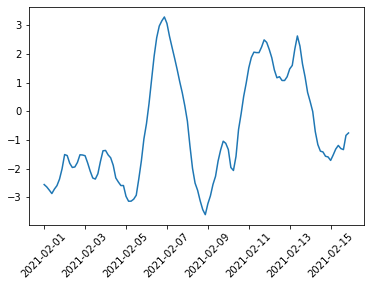

In [154]:
year = 2021

month = 2

vort_data = pickle.load(open(f'{data_dir}{year}_mean_vort.p','rb'))

times_month = vort_data['times'][month]
vorts_month = vort_data['mean_vort'][month]

t0 = datetime.datetime(1900,1,1)

real_times = [t0 + datetime.timedelta(hours=int(s)) for s in vort_data['times'][month]]

print(times_month.shape)

max_vort = np.min(vort_data['mean_vort'][month])

mean_vort = np.mean(vort_data['mean_vort'][month])

mean_vort_2021 = mean_vort.copy()

print(f'Mean vorticity in basin: {mean_vort}')

print(max_vort)

ind_max = np.where(vort_data['mean_vort'][month]==max_vort)[0][0]

print(ind_max)

print(real_times[ind_max])

# print(real_times)

plt.plot(real_times,vorts_month)
plt.xticks(rotation=45)

print(real_times[-1])

In [148]:
all_vort = []

month = 2

mean_vorts_list = []

print(f'Mean vorticity for Feb 2021: {mean_vort_2021}')

for year in tqdm.trange(1992,2021):

    vort_data = pickle.load(open(f'{data_dir}{year}_mean_vort.p','rb'))

    mean_vort_m = np.mean(vort_data['mean_vort'][month])
    print(year)
    print(mean_vort_m)
    
    mean_vorts_list.append(mean_vort_m)
    
    if mean_vort_m < mean_vort:
        print(year)
        print(max_vort_m)

100%|██████████| 29/29 [00:00<00:00, 1036.11it/s]

Mean vorticity for Feb 2021: -0.6311234792073568
1992
0.0032314432078394397
1993
0.9823110444205148
1994
-0.6263678414481026
1995
0.0054795656885419574
1996
2.139270914011988
1997
-0.21985289028712682
1998
0.442422662462507
1999
1.0313307217189245
2000
0.26968530128742085
2001
0.9155195781162807
2002
1.2950188773018974
2003
-0.19503435066768102
2004
0.04005206864455651
2005
0.6278164046151298
2006
2.725569588797433
2007
0.6954029628208706
2008
1.28771946347993
2009
0.6031714848109654
2010
0.4724592481340681
2011
1.2592457362583704
2012
0.40412942294416754
2013
-0.1840336663382394
2014
-0.5408095291682652
2015
0.021125963756016324
2016
0.2348455889471646
2017
0.17341620581490652
2018
1.1367529460362025
2019
1.609079224722726
2020
1.928924560546875


100%|██████████| 29/29 [00:00<00:00, 869.51it/s]


1992
-4.512471
1994
-4.918846
1996
-4.6937966
1997
-3.6829245
1998
-3.830173
2000
-4.783695
2003
-4.070669
2004
-5.7936616
2007
-3.6890292
2012
-4.009509
2013
-4.034891
2014
-4.9143896
2015
-6.563868
2016
-4.00538
2018
-5.3757544
2019
-3.8420992


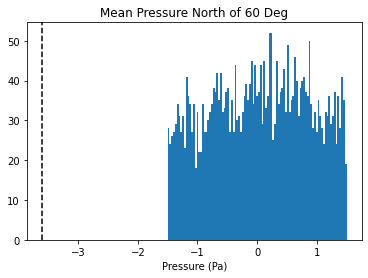

In [133]:
all_vort = []

month = 2

max_vorts_list = []

rec_21 = max_vort

for year in tqdm.trange(1992,2021):

    vort_data = pickle.load(open(f'{data_dir}{year}_mean_vort.p','rb'))

    vort_for_month = list(vort_data['mean_vort'][month])
    
    max_vort_m = np.min(vort_for_month)
    
    max_vorts_list.append(max_vort_m)
    
    if max_vort_m < rec_21:
        print(year)
        print(max_vort_m)
    
    all_vort += vort_for_month
    
    
plt.axvline(x=rec_21,color='k',ls='--')
plt.hist(all_vort,
         bins=np.linspace(-1.5,1.5,100),
        )
plt.title('Mean Pressure North of 60 Deg')
plt.xlabel('Pressure (Pa)')
plt.show()

Text(0.5, 0, 'Year')

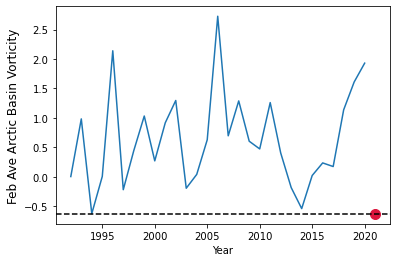

In [151]:
plt.plot(range(1992,2021),mean_vorts_list)
plt.plot(2021,mean_vort_2021,marker='o', color='crimson',markersize=10)
plt.axhline(mean_vort_2021,color='k',ls='--')
plt.ylabel('Feb Ave Arctic Basin Vorticity', fontsize='large')
plt.xlabel('Year')

In [31]:
p = pickle.load(open('/home/robbie/Dropbox/beaufort_sea/vorticity_files/1992_mean_vort.p','rb'))

p.keys()

dict_keys(['mean_slps', 'times'])

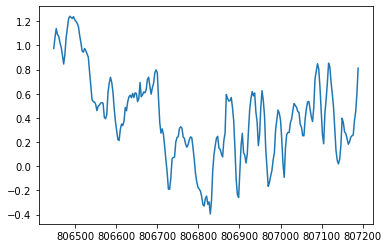

In [32]:
plt.plot(p['times'][1],p['mean_slps'][1])

In [22]:
np.array(ao_feb['year'])

array(['1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957',
       '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981',
       '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
      dtype=object)

In [44]:
import mask

In [70]:
lon = mask.get('lon')
lat = mask.get('lat')
m = mask.get('mask')
from importlib import reload
import regrid
from regrid import griddata
import xarray as xr

In [50]:
adata = Dataset('/home/robbie/Dropbox/beaufort_sea/iceage_nh_12.5km_20200101_20210204_ql.nc')
alons = np.array(adata['longitude'])
alats = np.array(adata['latitude'])

In [75]:
ds = xr.Dataset( data_vars={'mask':(['x','y'],x)},

                 coords =  {'lon':(['x','y'],alons),
                            'lat':(['x','y'],alats)})

ds.to_netcdf(f'mask720.nc','w')

In [76]:
d = Dataset('mask720.nc')

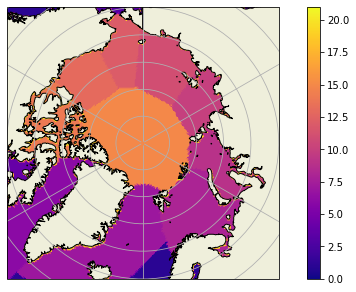

In [79]:
from cartoplot import cartoplot

cartoplot(d['lon'],d['lat'],d['mask'])

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  


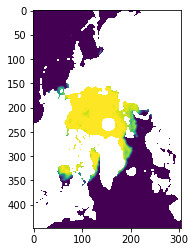

In [83]:
d = Dataset('/media/robbie/TOSHIBA EXT/nsidc_cdr_conc/seaice_conc_monthly_nh_f08_198712_v03r01.nc')
plt.imshow(d['goddard_nt_seaice_conc_monthly'][0])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.6, ACDD-1.3
    title: NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration Version 3
    references: Comiso, J. C., and F. Nishio. 2008. Trends in the Sea Ice Cover Using Enhanced and Compatible AMSR-E, SSM/I, and SMMR Data. Journal of Geophysical Research 113, C02S07, doi:10.1029/2007JC0043257. ; Comiso, J. C., D. Cavalieri, C. Parkinson, and P. Gloersen. 1997. Passive Microwave Algorithms for Sea Ice Concentrations: A Comparison of Two Techniques. Remote Sensing of the Environment 60(3):357-84. ; Comiso, J. C. 1984. Characteristics of Winter Sea Ice from Satellite Multispectral Microwave Observations. Journal of Geophysical Research 91(C1):975-94. ; Cavalieri, D. J., P. Gloersen, and W. J. Campbell. 1984. Determination of Sea Ice Parameters with the NIMBUS-7 SMMR. Journal of Geophysical Research 89(D4):5355-5369. ; Cavalieri, D. J., C. l. Parkinson

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  This is separate from the ipykernel package so we can avoid doing imports until


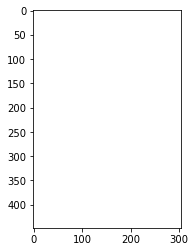

In [80]:
.